In [1]:
%pip install typing-extensions
%pip install requests
%pip install pandas
%pip install numpy
%pip install tensorflow
%pip install pillow

Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/avx2, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
Note: you may need to restart the kernel to use updated packages.
Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/avx2, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
Note: you may need to restart the kernel to use updated packages.
Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/avx2, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
Note: you may need to restart the kernel to use updated packages.
Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/avx2, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/gener

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
import pandas as pd
import numpy as np
from os import listdir, makedirs, remove
from os.path import join, isdir, exists, dirname
from shutil import move, rmtree
from PIL import Image
from PIL import ImageFile
import PIL

2023-06-30 15:05:18.505880: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-30 15:05:18.919350: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-30 15:05:21.248070: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
tf.compat.v1.disable_eager_execution()

LABEL = '/scratch/jhowe4/outputs/GDC/paad_example2/labels.csv'
ERR_FILE = '/scratch/jhowe4/outputs/GDC/paad_example2/corrupt_images_log.txt'

In [3]:
def extract_labels(ds):
  labels = []
  num_batches = len(ds)
  for batch_idx in range(num_batches):
    _, batch_labels = ds[batch_idx]
    labels.extend(batch_labels)
  
  labels = np.array(labels)
  return labels 

In [57]:
# Make sure the error file is clean
if exists(ERR_FILE):
  remove(ERR_FILE)

# Create data generator
datagen = ImageDataGenerator(
  rescale=1/255,
  preprocessing_function=preprocess_input
)
  
# Training dataset
train_ds = datagen.flow_from_directory(
  '/scratch/jhowe4/outputs/GDC/paad_example2/train',
  target_size=(224, 224),
  class_mode='binary',
  batch_size=32
)
  
# Testing dataset
test_ds = datagen.flow_from_directory(
  '/scratch/jhowe4/outputs/GDC/paad_example2/test',
  target_size=(224, 224),
  class_mode='binary',
  batch_size=32
)
  
# Validation dataset
valid_ds = datagen.flow_from_directory(
  '/scratch/jhowe4/outputs/GDC/paad_example2/valid',
  target_size=(224, 224),
  class_mode='binary',
  batch_size=32
)

Found 32434 images belonging to 2 classes.
Found 1363 images belonging to 2 classes.
Found 3880 images belonging to 2 classes.


In [61]:
# Build model
model = tf.keras.Sequential()

# Transfer learning
model.add(tf.keras.applications.ResNet50(include_top = False, pooling = 'avg', weights ='imagenet'))
  
# 2nd layer as Dense for 2-class classification
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))
  
# Not training the resnet on the new data set. Using the pre-trained weigths
model.layers[0].trainable = False  
  
# compile the model
model.compile(
  optimizer = 'adam', 
  loss = 'binary_crossentropy', 
  metrics = [tf.keras.metrics.AUC(name="auc")])

2023-06-30 12:46:17.351481: W tensorflow/c/c_api.cc:300] Operation '{name:'conv4_block4_3_bn_5/moving_mean/Assign' id:38281 op device:{requested: '', assigned: ''} def:{{{node conv4_block4_3_bn_5/moving_mean/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv4_block4_3_bn_5/moving_mean, conv4_block4_3_bn_5/moving_mean/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [71]:
# Find the prevalence of each class in the test dataset
pos = 0
neg = 0
num_batches = len(test_ds)
for batch_idx in range(num_batches):
    _, batch_labels = test_ds[batch_idx]
    for label in batch_labels:
        if label == 1:
            pos = pos + 1
        elif label == 0:
            neg = neg + 1

total = pos + neg
print(f"Number of Positive Samples: {pos}\nNumber of Negative Samples: {neg}")
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}
print('Weight for class 0: {:.2f}' .format(weight_for_0))
print('Weight for class 1: {:.2f}' .format(weight_for_1))

Number of Positive Samples: 1072
Number of Negative Samples: 291
Weight for class 0: 2.34
Weight for class 1: 0.64


In [1]:
  # Fit the model
  fit_history = model.fit(
    train_ds,
    steps_per_epoch=4,
    validation_data=test_ds,
    validation_steps=4,
    epochs=10,
    class_weight=class_weight
  )
  
  # Save the model weights
  weights_path = '../model/weights/tf-2023-06-30_weights.h5'
  weights_dir = dirname(weights_path)
  if not isdir(weights_dir):
    makedirs(weights_dir)
  model.save_weights(weights_path)

NameError: name 'model' is not defined

In [74]:
  # Evaluate model
  eval_result = model.evaluate(
    valid_ds,
    steps=len(valid_ds)
  )
  print("[test loss, test auc]:", eval_result)
  
  y_pred = model.predict(valid_ds)
  y_true = extract_labels(valid_ds)
  
  print(f"Predicted labels: {len(y_pred)}")

  print(f"True labels: {len(y_true)}")

[test loss, test auc]: [0.5323823675757549, 0.5276785]
Predicted labels: 3880
True labels: 3880


In [14]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [1]:
%pip install scikit-learn
%pip install matplotlib

Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/avx2, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/generic/scikit_learn-1.2.1+computecanada-cp310-cp310-linux_x86_64.whl
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic/joblib-1.3.1+computecanada-py3-none-any.whl (from scikit-learn)
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic/threadpoolctl-3.1.0+computecanada-py3-none-any.whl (from scikit-learn)
Note: you may need to restart the kernel to use updated packages.
Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/avx2, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
Note: you may need to restart the kernel to use updated packages.


In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

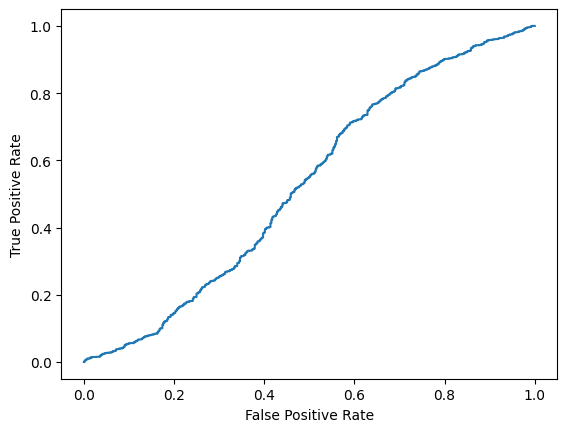

In [75]:
def plot_roc_curve(y_true, y_pred):
    """
    plots the roc curve based off the probabilities
    """
    
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(y_true, y_pred)

In [73]:
for i in range(10):
    print(y_pred[i])

[0.6569835]
[0.6506831]
[0.62848556]
[0.64687103]
[0.63364977]
[0.65611845]
[0.64889157]
[0.66468805]
[0.6547369]
[0.64791906]
